<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Fine-tuning an Action Recognition Model on HMDB51

In this notebook, we demonstrate how to get the SOTA results for the [HMDB51](http://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/) human action dataset using the R(2+1)D model.

## Initialization

Import all the functions we need

In [1]:
import sys
sys.path.append("../../")
import time
import os
import numpy as np
import torch
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import requests
import warnings

from model import VideoLearner
from dataset import VideoRecord, VideoDataset
from data import Urls
from gpu import system_info
from data import data_path, download

system_info()
warnings.filterwarnings('ignore')

3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:43:00) 
[GCC 7.5.0] 

PyTorch 1.5.1 

Torch-vision 0.6.1 

Available devices:
0: GeForce RTX 2080 Ti


This shows your machine's GPUs (if it has any) and the computing device `torch/torchvision` is using.

In [2]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Next, set some model runtime parameters. 

Using the paramters below, one can reproduce published results on the HMDB-51 dataset. Video-clip accuracy of close to 80%  can be obtained using as input to the DNN 32 consecutive frames (`MODEL_INPUT_SIZE`) and running 48 training epochs. Even using only 8 epochs the accuracy already reaches 75%. Inference and training speed can be reduced by a factor of 3-4 by setting `MODEL_INPUT_SIZE=8` and using higher batch size, however at a significant loss in accuracy.

In [3]:
# Number of consecutive frames used as input to the DNN. Recommended: 32 for high accuracy, 8 for inference speed.
MODEL_INPUT_SIZE = 32

# Batch size. Reduce if running out of memory.
BATCH_SIZE = 4

# Number of training epochs
EPOCHS = 8

# Learning rate
LR = 0.0001

## Downloading HMDB51

Since we're trying to train our model ont he hmdb51 dataset, we'll need to download it. You find the link to download it [here](http://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database/). Once downloaded, set `VIDEO_DIR` to the location of the videos.

In [4]:
DATA_ROOT = os.path.join("data", "ucf101")
VIDEO_DIR = os.path.join(DATA_ROOT, "videos")
VIDEO_DIR2 = os.path.join(DATA_ROOT, "videos2")

In [5]:
DATA_ROOT

'data/ucf101'

For this notebook, we'll try to reproduce the SOTA results on HMDB51 using a specific train/test split known simply as "split1". Download the split and specify where the download location.

In [6]:
TRAIN_SPLIT = os.path.join(DATA_ROOT, "train.txt")
TEST_SPLIT = os.path.join(DATA_ROOT, "test.txt")

---

# Prepare HMDB51 using the Video Dataset

We can load the downloaded HMBD51 dataset into our `VideoDataset` class by simply passing it the location of the folder. We demonstrated how this is done in the previous [01_training_introduction.ipynb](./01_training_notebook.ipynb) notebook. 

However, because we're trying to reproduce the results in the paper, we'll have to use a specific split of the training and testing data as defined by the `TRAIN_SPLIT` and `TEST_SPLIT` files. This is refered to in the paper as "split1". Conviniently, the `VideoDataset` class can take in a __train_split_file__ and a __test_split_file__ as parameters, so we can pass it directly into the VideoDataset.

For these parameters to work, the file must come in the following format:
```
<action_type>/<video_name> <label_number>
```

Here's what the top part __hmdb51_vid_train_split_1.txt__ looks like.
```
fencing/AHF_Rapier_fencing_f_cm_np2_le_bad_2 13
situp/Timed_situps_1_minute_situp_f_nm_np1_ri_med_1 38
brush_hair/Aussie_Brunette_Brushing_Hair_II_brush_hair_u_nm_np2_le_goo_0 0
swing_baseball/BaseballHitinSlowMotion_swing_baseball_f_nm_np1_le_bad_1 43
clap/#20_Rhythm_clap_u_nm_np1_le_goo_3 4
laugh/Skype_Laughter_by_Hungary_laugh_h_nm_np2_fr_goo_1 23
ride_horse/ChampagneRunattheParkHT_ride_horse_f_cm_np1_ri_med_1 31
swing_baseball/practicingmybaseballswing2009_swing_baseball_f_cm_np1_fr_med_5 43
...
```

Notice that the extension (".mp3", ".avi") is passed in separately.

In [7]:
data = VideoDataset(
    VIDEO_DIR,
    train_split_file=TRAIN_SPLIT,
    test_split_file=TEST_SPLIT,
    batch_size=BATCH_SIZE,
    sample_length=MODEL_INPUT_SIZE,
    video_ext="avi"
)

In [8]:
data2 = VideoDataset(
    VIDEO_DIR2,
    train_split_file=TRAIN_SPLIT,
    test_split_file=TEST_SPLIT,
    batch_size=BATCH_SIZE,
    sample_length=MODEL_INPUT_SIZE
)

Here's what the train/test split ends up looking like.

In [9]:
print(
    f"Training dataset: {len(data.train_ds)} | Training DataLoader: {data.train_dl} \
    \nTesting dataset: {len(data.test_ds)} | Testing DataLoader: {data.test_dl}"
)

Training dataset: 5377 | Training DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f5a5d9eafa0>     
Testing dataset: 1388 | Testing DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f5a5814b5e0>


Now that the data is loaded, we can take a quick look at some samples.

In [ ]:
data.show_batch(rows=2)

Lets also take a look at the (default) parameters that we're using:

In [9]:
print(f"""\
sample_length: {data.sample_length}
sample_step: {data.sample_step}
temporal_jitter: {data.temporal_jitter}
temporal_jitter_step: {data.temporal_jitter_step}
random_shift: {data.random_shift}
""")

sample_length: 32
sample_step: 1
temporal_jitter: True
temporal_jitter_step: 2
random_shift: True



## Setup the Video Learner

In [11]:
learner = VideoLearner(data, num_classes=51)

Loading r2plus1d_34_32_ig65m model


Using cache found in /home/shkim/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


In [12]:
learner.model.fc

Linear(in_features=512, out_features=51, bias=True)

Params to learn:
	full network
Epoch 1 =========================================================
lr=[0.0001]
 Phase train: batch 200 of 1345
 Phase train: batch 400 of 1345
 Phase train: batch 600 of 1345
 Phase train: batch 800 of 1345
 Phase train: batch 1000 of 1345
 Phase train: batch 1200 of 1345
train took 783.59 sec | loss = 2.9715 | top1_acc = 33.5503  | top5_acc = 64.8317
 Phase valid: batch 200 of 347
valid took 57.48 sec | loss = 1.6209 | top1_acc = 55.9798  | top5_acc = 85.2305
Epoch 2 =========================================================
lr=[0.0001]
 Phase train: batch 200 of 1345
 Phase train: batch 400 of 1345
 Phase train: batch 600 of 1345
 Phase train: batch 800 of 1345
 Phase train: batch 1000 of 1345
 Phase train: batch 1200 of 1345
train took 777.63 sec | loss = 1.6434 | top1_acc = 68.2909  | top5_acc = 91.4822
 Phase valid: batch 200 of 347
valid took 57.76 sec | loss = 1.1935 | top1_acc = 70.3170  | top5_acc = 90.7060
Epoch 3 =================================

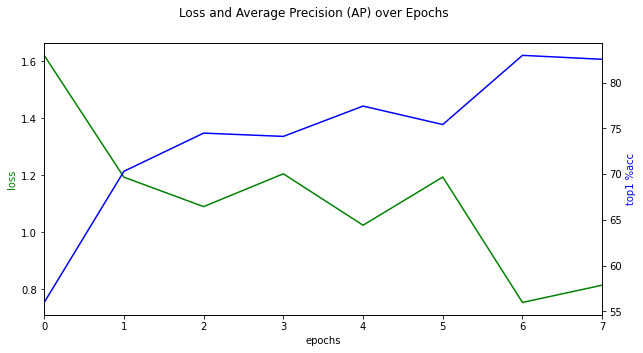

In [24]:
learner.fit(lr=LR, epochs=EPOCHS)

# Training 4-dim

In [10]:
train_len = len(data.train_ds)
train_range = torch.arange(0, len(data.train_ds))
test_range = torch.arange(0, len(data.test_ds))

In [ ]:
z = []
for i in range(len(data.train_ds)):    
    x, a = list(data.train_ds[i])
    y, b = list(data2.train_ds[i])
    z.append((torch.cat([x, y[0:1]], dim=0), a))


In [ ]:
import copy
from torch.utils.data import Dataset, Subset, DataLoader

In [ ]:
data2.train_ds = copy.deepcopy(Subset(z, train_range))

In [ ]:
z = []
for i in range(len(data.test_ds)):    
    x, a = list(data.test_ds[i])
    y, b = list(data2.test_ds[i])
    z.append((torch.cat([x, y[0:1]], dim=0), a))
data2.test_ds = copy.deepcopy(Subset(z, test_range))

In [18]:
data2.train_dl = DataLoader(
    data2.train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,#########
    num_workers=1,
    pin_memory=True,
)

data2.test_dl = DataLoader(
    data2.test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [19]:
learner_4dim = VideoLearner(data2, num_classes=51)
learner_4dim.model.stem[0] = nn.Conv3d(4, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)

Loading r2plus1d_34_32_ig65m model


Using cache found in /home/shkim/.cache/torch/hub/moabitcoin_ig65m-pytorch_master


In [20]:
learner.model.stem[0]

Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)

In [21]:
a = learner.model.stem[0].weight.clone()
b = a[:,0:1,...] + a[:,1:2,...] + a[:,2:3,...] / 3
a = torch.cat([a, b], dim = 1)
a.shape

torch.Size([45, 4, 1, 7, 7])

In [22]:
with torch.no_grad():
    learner_4dim.model.stem[0].weight.copy_(a)

In [23]:
learner_4dim.model.stem[0].weight.is_leaf

True

Params to learn:
	full network
Epoch 1 =========================================================
lr=[0.0001]
 Phase train: batch 200 of 1345
 Phase train: batch 400 of 1345
 Phase train: batch 600 of 1345
 Phase train: batch 800 of 1345
 Phase train: batch 1000 of 1345
 Phase train: batch 1200 of 1345
train took 772.47 sec | loss = 3.0772 | top1_acc = 30.0725  | top5_acc = 60.2195
 Phase valid: batch 200 of 347
valid took 52.37 sec | loss = 1.9076 | top1_acc = 51.0086  | top5_acc = 84.4380
Epoch 2 =========================================================
lr=[0.0001]
 Phase train: batch 200 of 1345
 Phase train: batch 400 of 1345
 Phase train: batch 600 of 1345
 Phase train: batch 800 of 1345
 Phase train: batch 1000 of 1345
 Phase train: batch 1200 of 1345
train took 773.61 sec | loss = 1.7772 | top1_acc = 63.9948  | top5_acc = 89.8084
 Phase valid: batch 200 of 347
valid took 52.14 sec | loss = 1.5093 | top1_acc = 63.1844  | top5_acc = 86.0230
Epoch 3 =================================

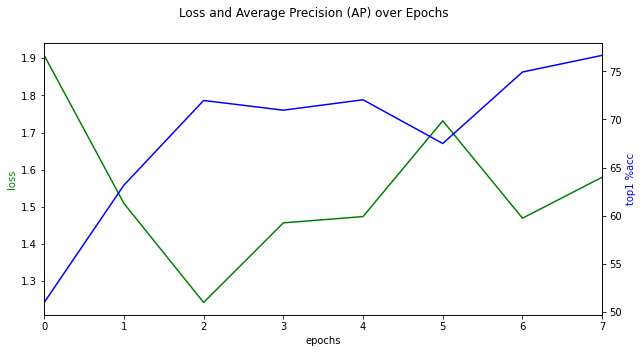

In [25]:
learner_4dim.fit(lr=LR, epochs=EPOCHS)

## Model Test

Finally, we want to evaluate our model on our test set. To do so, we'll uniformly sample 10 clips from each test video, to produce a tensor of [10 x 3 x (8 or 32) x 112 x 112] that we call our prediction on. This will give us the *clip-level accuracy* for batches of 10 at time. We also want to calculate the *video-level accuracy* which we can get by simply averaging the clip-level accuracy.

In [ ]:
ret = learner.evaluate()

The reported accuracy from "Closer look" paper is 74.5% (clip accuracy of 66.1% on split1 based on VMZ repo). You can see that by using the following parameters, we are able to reproduce the state of the art result at ~77% accuracy.
```
MODEL_INPUT_SIZE = 32
BATCH_SIZE = 4
EPOCHS = 8
LR = 0.0001
```